In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import numpy as np

In [9]:
# Load Data
df = pd.read_csv('data/email_marketing_campaign.csv')

In [11]:
# 1. Quick Data Check
print(f"Total Rows: {df.shape[0]}")
print(f"Segments: {df['segment'].unique()}")

Total Rows: 64000
Segments: ['Womens E-Mail' 'No E-Mail' 'Mens E-Mail']


In [12]:
# 2. Rename columns for clarity
# In Uplift modeling, we usually have:
# T (Treatment): Did they get the email?
# Y (Outcome): Did they convert?
df = df.rename(columns={'conversion': 'target_class'})

In [13]:
# 3. Create a binary 'treatment' flag for simpler analysis
# We will focus on 'Mens E-Mail' vs 'No E-Mail' first (ignore Womens for now)
df_men = df[df['segment'].isin(['Mens E-Mail', 'No E-Mail'])].copy()
df_men['treatment'] = df_men['segment'].apply(lambda x: 1 if x == 'Mens E-Mail' else 0)

In [14]:
print("\nData prepared for Men's Email Analysis.")
df_men.head()


Data prepared for Men's Email Analysis.


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,target_class,spend,treatment
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1
13,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0,1
14,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0.0,0


Feature Engineering

Control Conversion Rate: 0.5726%
Treated Conversion Rate: 1.2531%
------------------------------
ACTUAL UPLIFT: 0.6805% points


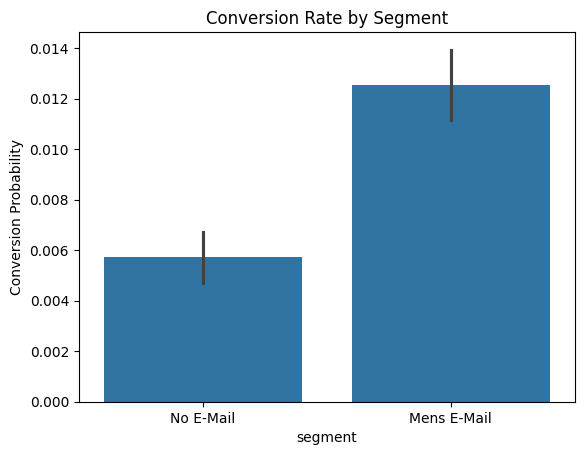

In [16]:
# Calculate Average conversion for Treated vs Control
uplift_summary = df_men.groupby('treatment')['target_class'].agg(['mean', 'sum', 'count'])
uplift_summary.columns = ['Conversion Rate', 'Total Conversions', 'Total Customers']

# Calculate the Lift (Difference)
control_conv = uplift_summary.loc[0, 'Conversion Rate']
treated_conv = uplift_summary.loc[1, 'Conversion Rate']
uplift = treated_conv - control_conv

print(f"Control Conversion Rate: {control_conv:.4%}")
print(f"Treated Conversion Rate: {treated_conv:.4%}")
print("-" * 30)
print(f"ACTUAL UPLIFT: {uplift:.4%} points")

# Visualize it
sns.barplot(x=df_men['segment'], y=df_men['target_class'])
plt.title("Conversion Rate by Segment")
plt.ylabel("Conversion Probability")
plt.show()

Model Training


In [19]:
# 1. Feature Engineering
# We need to convert text ('Rural', 'Web') into numbers for XGBoost
categorical_cols = ['zip_code', 'channel', 'history_segment']
df_model = pd.get_dummies(df_men, columns=categorical_cols, drop_first=True)

In [20]:
# Define X (Features), y (Outcome), and t (Treatment)
X = df_model.drop(['treatment', 'target_class', 'segment', 'visit', 'spend'], axis=1)
y = df_model['target_class']
t = df_model['treatment']

In [21]:
# 2. Split Data (Train vs Test)
# We hide 20% of data to test if our model actually works
X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
    X, y, t, test_size=0.2, random_state=42, stratify=t
)

print(f"Training Data Shape: {X_train.shape}")

Training Data Shape: (34090, 15)


In [22]:
# 3. The T-Learner Architecture
# Separate the training data into 'Treated' and 'Control'
X_train_ctrl = X_train[t_train == 0]
y_train_ctrl = y_train[t_train == 0]

X_train_tr = X_train[t_train == 1]
y_train_tr = y_train[t_train == 1]

In [23]:
# 4. Train the Models 

model_ctrl = xgb.XGBClassifier(tree_method="hist", device="cuda", enable_categorical=True)
model_tr = xgb.XGBClassifier(tree_method="hist", device="cuda", enable_categorical=True)

print("Training Control Model...")
model_ctrl.fit(X_train_ctrl, y_train_ctrl)

print("Training Treatment Model...")
model_tr.fit(X_train_tr, y_train_tr)

Training Control Model...
Training Treatment Model...


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [24]:
# 5. Predict Uplift
# We ask BOTH models to predict for the TEST set
pred_ctrl = model_ctrl.predict_proba(X_test)[:, 1] # Probability of buying WITHOUT email
pred_tr = model_tr.predict_proba(X_test)[:, 1]     # Probability of buying WITH email

# Uplift = P(Buy | Email) - P(Buy | No Email)
uplift_score = pred_tr - pred_ctrl

# Add scores to a results dataframe
df_results = X_test.copy()
df_results['uplift_score'] = uplift_score
df_results['true_outcome'] = y_test
df_results['treatment'] = t_test

print("\nUplift Scores Calculated!")
print(df_results[['uplift_score']].head())


Uplift Scores Calculated!
       uplift_score
41663      0.000597
57162     -0.021197
23188      0.001651
8128      -0.016221
10916     -0.000015


/home/thathsara/miniforge3/envs/ds_lab/lib/python3.10/site-packages/xgboost/core.py:774: UserWarning: [10:57:05] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


/tmp/ipykernel_24374/1317879970.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  uplift_by_decile = df_results.groupby('uplift_decile').apply(calculate_actual_lift).reset_index(name='actual_uplift')
/tmp/ipykernel_24374/1317879970.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='uplift_decile', y='actual_uplift', data=uplift_by_decile, palette="viridis")


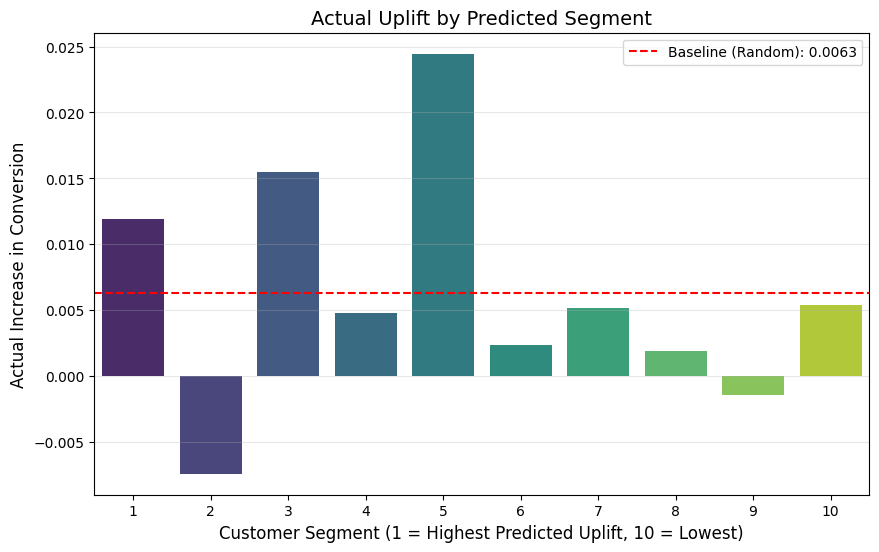

In [26]:
# 1. Segment users into Deciles (Top 10% best scores, etc.)
# We want 10 bins, labeled 1 (Top) to 10 (Bottom)
df_results['uplift_decile'] = pd.qcut(df_results['uplift_score'], 10, labels=False, duplicates='drop')
df_results['uplift_decile'] = 10 - df_results['uplift_decile'] # Reverse so 1 is Top

# 2. Calculate Actual Uplift per Decile
# For each bin, we manually calculate: (Conversion | Treated) - (Conversion | Control)
def calculate_actual_lift(group):
    control_conv = group[group['treatment'] == 0]['true_outcome'].mean()
    treated_conv = group[group['treatment'] == 1]['true_outcome'].mean()
    return treated_conv - control_conv

uplift_by_decile = df_results.groupby('uplift_decile').apply(calculate_actual_lift).reset_index(name='actual_uplift')

# 3. Plot the "Money Chart"
plt.figure(figsize=(10, 6))
sns.barplot(x='uplift_decile', y='actual_uplift', data=uplift_by_decile, palette="viridis")

# Add a red line for the "Average Uplift" (Random Emailing)
avg_uplift = df_results[df_results['treatment']==1]['true_outcome'].mean() - df_results[df_results['treatment']==0]['true_outcome'].mean()
plt.axhline(y=avg_uplift, color='r', linestyle='--', label=f'Baseline (Random): {avg_uplift:.4f}')

plt.title("Actual Uplift by Predicted Segment", fontsize=14)
plt.xlabel("Customer Segment (1 = Highest Predicted Uplift, 10 = Lowest)", fontsize=12)
plt.ylabel("Actual Increase in Conversion", fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()